In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud ,STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize

from google.colab import drive

import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel("/content/drive/MyDrive/veriler.xlsx")


In [ ]:
data.head()

Haber Gövdesi            Sınıf
0  Zürih''teki yapılan araştırmada stresli kişile...  Bilim-Teknoloji
1  Zürih''teki İsviçre Federal Teknoloji Enstitüs...  Bilim-Teknoloji
2  Zuckerberg bu tür içerikler yerine, ön sayfada...  Bilim-Teknoloji
3  Zuckerberg ABD Kongresi'nden Facebook kullanıc...  Bilim-Teknoloji
4  Zorla yeniden başlatma, telefonun yerleşik ola...  Bilim-Teknoloji

# Haber Kategorileri


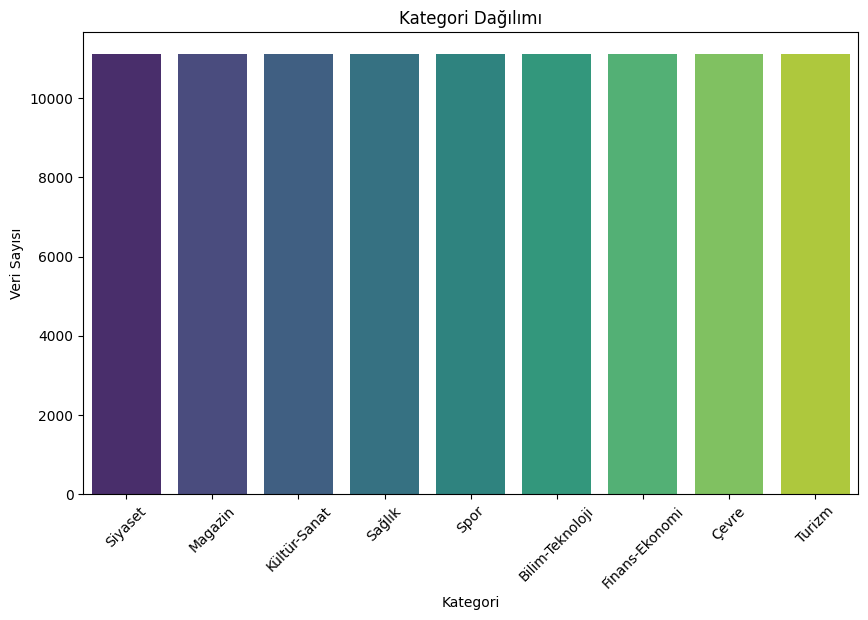

In [ ]:
# Count the occurrences of each category
category_counts = data['Sınıf'].value_counts()

# Plot the distribution of categories
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Kategori Dağılımı')
plt.xlabel('Kategori')
plt.ylabel('Veri Sayısı')
plt.xticks(rotation=45)  # Rotate x-labels for better readability
plt.show()

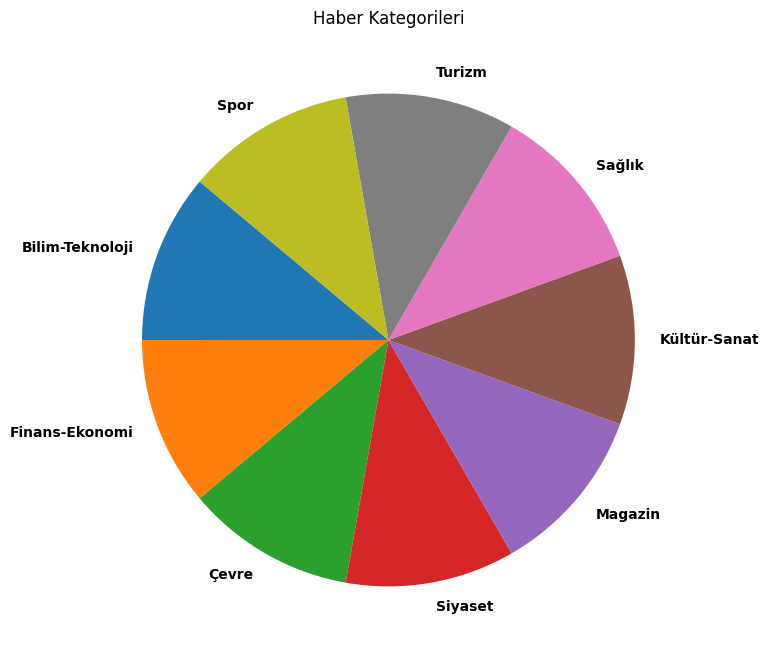

In [ ]:
# Calculate class counts
class_counts = data['Sınıf'].value_counts()

# Get unique class names
class_names = data['Sınıf'].unique()

# Plot pie chart without percentage values inside the sectors with bold labels
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, startangle=140, textprops={'fontweight': 'bold'})
plt.title('Haber Kategorileri')
plt.show()



#Haber Uzunluk Grafiği

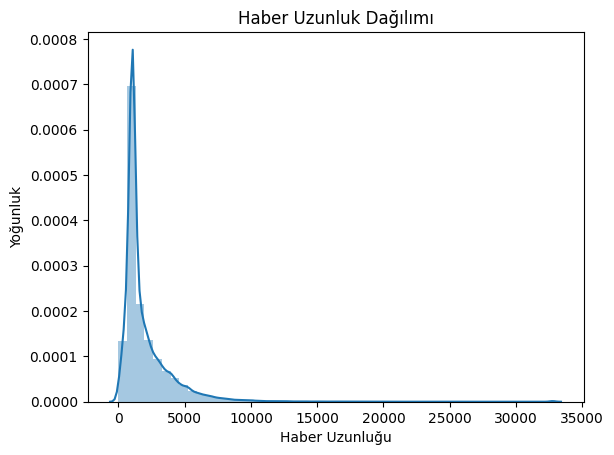

Ortalama Haber Uzunluğu: 2016.8233029321173


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it already has a column named 'Haber Gövdesi'
# Step 1: Calculate the length of each news article
data['Haber_Uzunluğu'] = data['Haber Gövdesi'].str.len()

# Step 2: Plot the distribution of news article lengths
sns.distplot(data['Haber_Uzunluğu']).set_title('Haber Uzunluk Dağılımı')
plt.xlabel('Haber Uzunluğu')
plt.ylabel('Yoğunluk')
plt.show()

# Step 3: Compute the mean length of the news articles
ortalama_haber_uzunlugu = data['Haber_Uzunluğu'].mean()
print("Ortalama Haber Uzunluğu:", ortalama_haber_uzunlugu)


#Veri Tipleri

In [ ]:
data.dtypes

Haber Gövdesi      object
Sınıf              object
Haber_Uzunluğu    float64
dtype: object

# Checking for NULL values

In [ ]:
data.isnull().any()

Haber Gövdesi      True
Sınıf             False
Haber_Uzunluğu     True
dtype: bool

#Metinleri Stopword ve Gereksiz İşaretlerden Temizleme

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


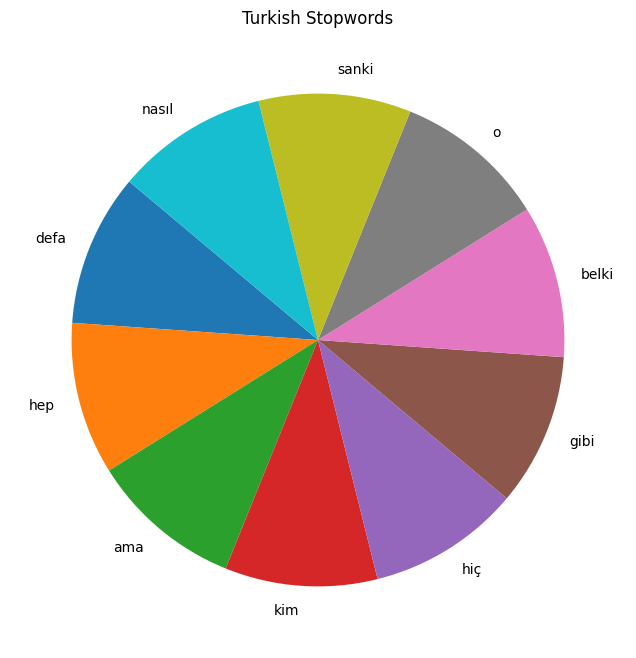

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')

def process_text(text):
    if isinstance(text, str):
        text = text.lower().replace('\n',' ').replace('\r','').strip()
        text = re.sub(' +', ' ', text)
        text = re.sub(r'[^\w\s]','',text)
        stop_words = set(stopwords.words('turkish'))
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        text = " ".join(filtered_sentence)

    return text


import matplotlib.pyplot as plt
import random

# Get the list of stopwords in Turkish
stop_words = stopwords.words('turkish')

# Randomly select a subset of stopwords
selected_stopwords = random.sample(stop_words, 10)

# Plot the selected stopwords in a pie chart
plt.figure(figsize=(8, 8))
plt.pie([1] * len(selected_stopwords), labels=selected_stopwords, startangle=140)
plt.title('Turkish Stopwords')
plt.show()





In [ ]:
data['Temiz_Haber_Gövdesi'] = data['Haber Gövdesi'].apply(process_text)

In [ ]:
data.head()

Haber Gövdesi            Sınıf  \
0  Zürih''teki yapılan araştırmada stresli kişile...  Bilim-Teknoloji   
1  Zürih''teki İsviçre Federal Teknoloji Enstitüs...  Bilim-Teknoloji   
2  Zuckerberg bu tür içerikler yerine, ön sayfada...  Bilim-Teknoloji   
3  Zuckerberg ABD Kongresi'nden Facebook kullanıc...  Bilim-Teknoloji   
4  Zorla yeniden başlatma, telefonun yerleşik ola...  Bilim-Teknoloji   

   Haber_Uzunluğu                                Temiz_Haber_Gövdesi  
0          1502.0  zürihteki yapılan araştırmada stresli kişileri...  
1          2133.0  zürihteki isviçre federal teknoloji enstitüsün...  
2          2312.0  zuckerberg tür içerikler yerine ön sayfada faz...  
3          1382.0  zuckerberg abd kongresinden facebook kullanıcı...  
4          1339.0  zorla yeniden başlatma telefonun yerleşik olan...

# WordCloud

In [ ]:
def create_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

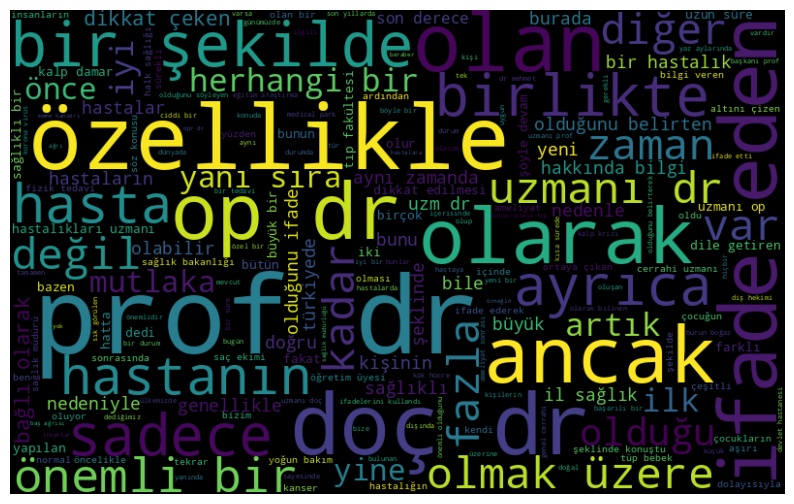

In [ ]:
subset = data[data.Sınıf == "Sağlık"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

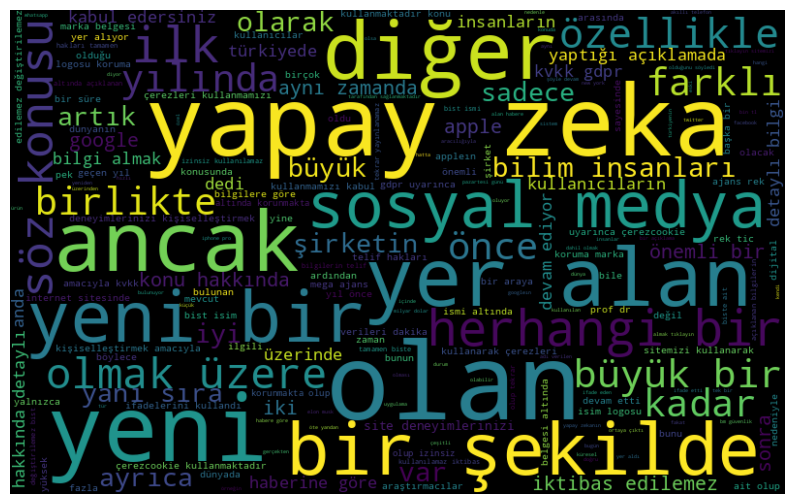

In [ ]:
subset = data[data.Sınıf == "Bilim-Teknoloji"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

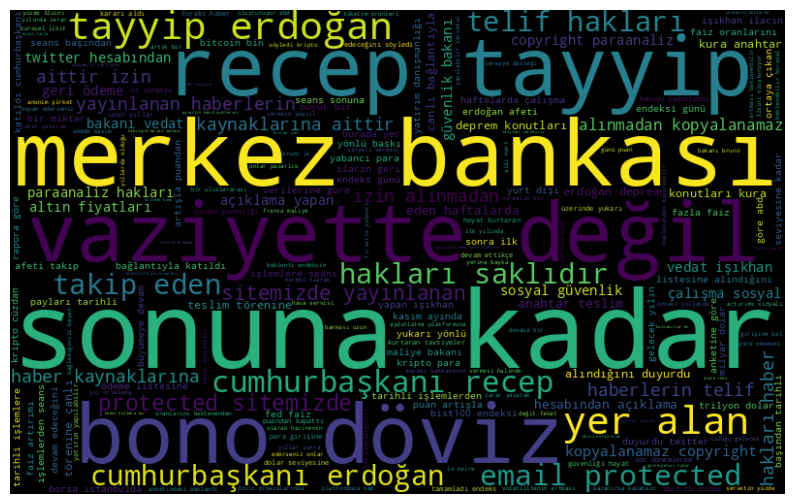

In [ ]:
subset = data[data.Sınıf == "Finans-Ekonomi"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

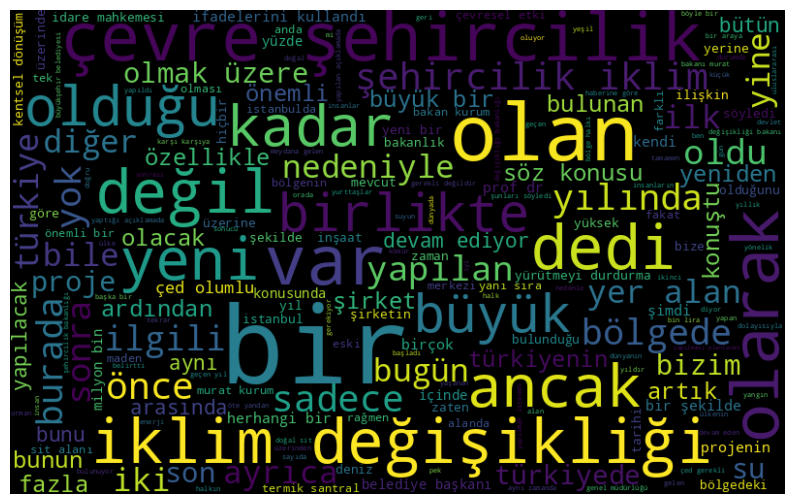

In [ ]:
subset = data[data.Sınıf == "Çevre"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

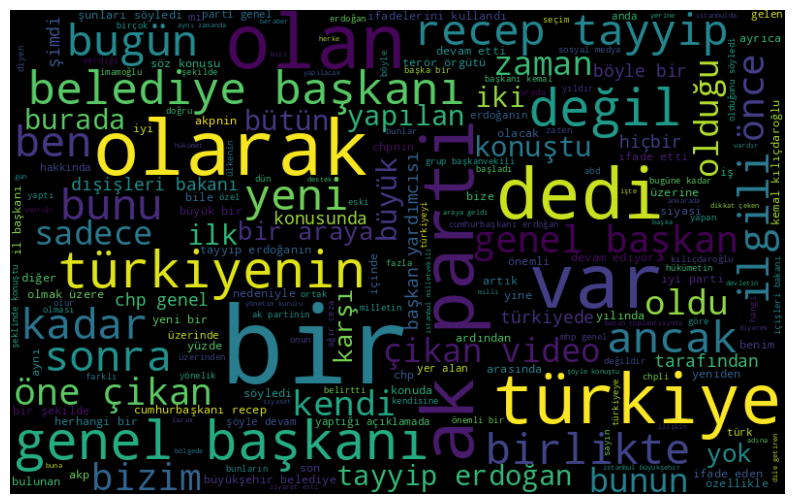

In [ ]:
subset = data[data.Sınıf == "Siyaset"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

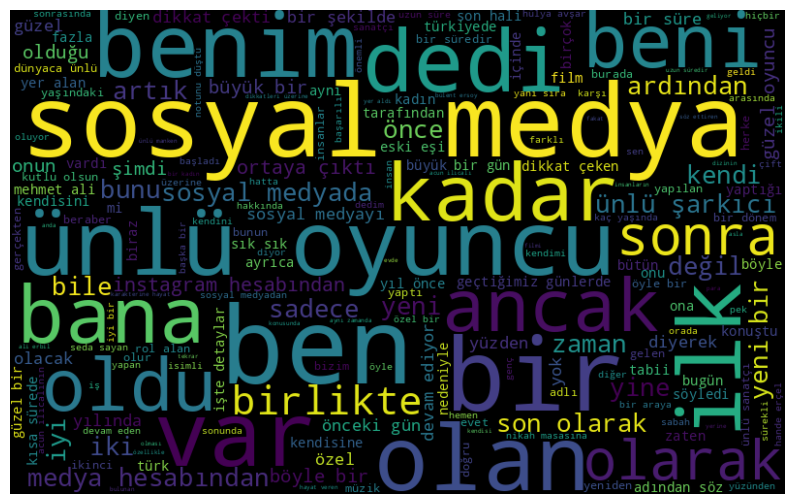

In [ ]:
subset = data[data.Sınıf == "Magazin"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

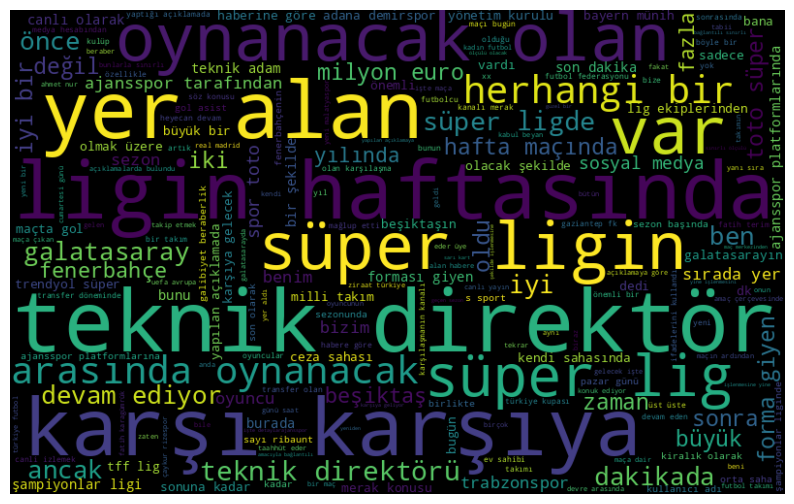

In [ ]:
subset = data[data.Sınıf == "Spor"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

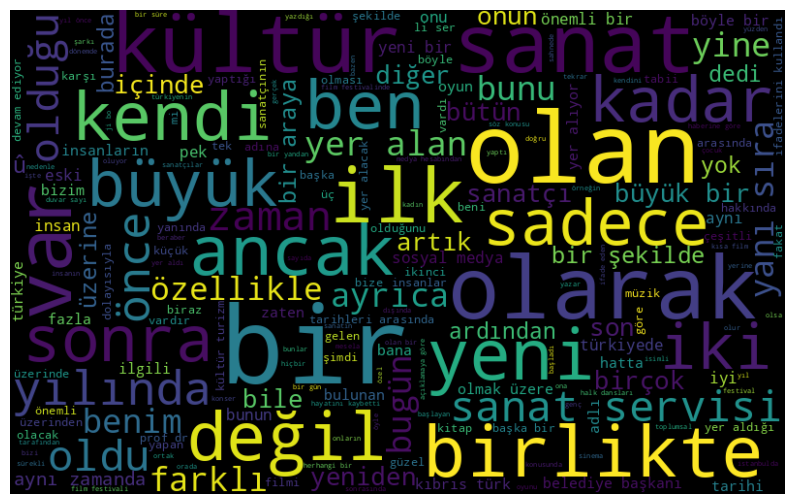

In [ ]:
subset = data[data.Sınıf == "Kültür-Sanat"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

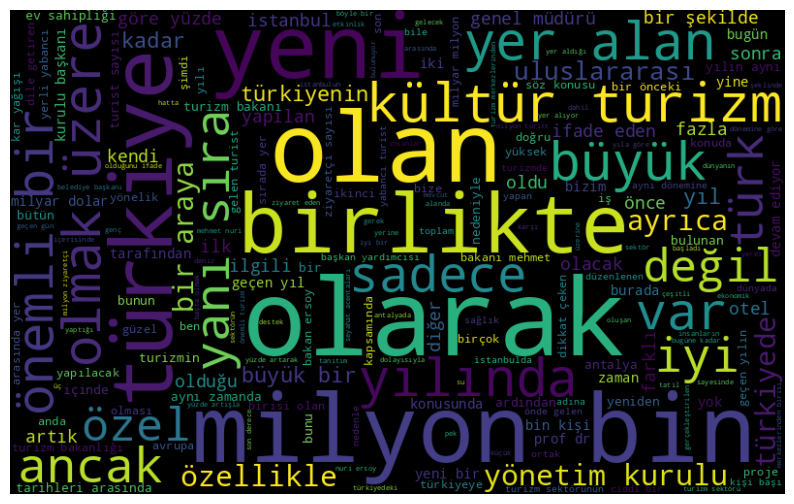

In [ ]:
subset = data[data.Sınıf == "Turizm"]
text = subset["Temiz_Haber_Gövdesi"].values.astype(str)
words = " ".join(text)
create_wordcloud(words)

# Label Encoding

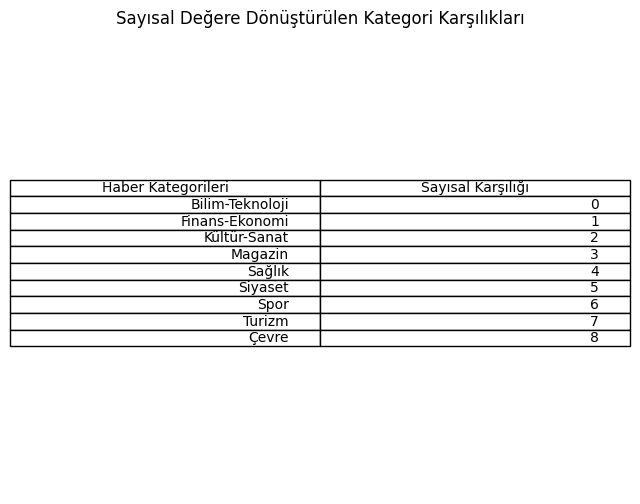

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['Sayısal_Sınıf']= label_encoder.fit_transform(data['Sınıf'])

import pandas as pd

# Create a DataFrame to store the class names and their corresponding numerical labels
class_label_df = pd.DataFrame({'Haber Kategorileri': label_encoder.classes_, 'Sayısal Karşılığı': label_encoder.transform(label_encoder.classes_)})

import matplotlib.pyplot as plt

# Plot the DataFrame as a table
plt.figure(figsize=(8, 6))
plt.table(cellText=class_label_df.values,
          colLabels=class_label_df.columns,
          loc='center')
plt.axis('off')  # Turn off axis
plt.title('Sayısal Değere Dönüştürülen Kategori Karşılıkları')
plt.show()


In [ ]:
data.head()

Haber Gövdesi            Sınıf  \
0  Zürih''teki yapılan araştırmada stresli kişile...  Bilim-Teknoloji   
1  Zürih''teki İsviçre Federal Teknoloji Enstitüs...  Bilim-Teknoloji   
2  Zuckerberg bu tür içerikler yerine, ön sayfada...  Bilim-Teknoloji   
3  Zuckerberg ABD Kongresi'nden Facebook kullanıc...  Bilim-Teknoloji   
4  Zorla yeniden başlatma, telefonun yerleşik ola...  Bilim-Teknoloji   

   Haber_Uzunluğu                                Temiz_Haber_Gövdesi  \
0          1502.0  zürihteki yapılan araştırmada stresli kişileri...   
1          2133.0  zürihteki isviçre federal teknoloji enstitüsün...   
2          2312.0  zuckerberg tür içerikler yerine ön sayfada faz...   
3          1382.0  zuckerberg abd kongresinden facebook kullanıcı...   
4          1339.0  zorla yeniden başlatma telefonun yerleşik olan...   

   Sayısal_Sınıf  
0              0  
1              0  
2              0  
3              0  
4              0

# Split the data in Training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['Temiz_Haber_Gövdesi'],
                                                    data['Sayısal_Sınıf'],
                                                    test_size=0.2,
                                                    random_state=8)


#N-Gram
ngram_range: Bu parametre, kullanılacak olan n-gram aralığını belirler. Örneğin, (1, 2) değeri, vektörleştirmede her kelimenin tek başına (unigram) veya iki kelimenin bir arada (bigram) olacak şekilde alınmasını sağlar.

min_df: Bu parametre, belirtilen değerden daha az belge içeren kelimelerin vektörize edilmesini önler. Örneğin, 10 değeri, en az 10 belgede bulunan kelimelerin vektörize edilmesini sağlar.

max_df: Bu parametre, belirtilen değeri aşan belge içeren kelimelerin vektörize edilmesini önler. Örneğin, 1.0 (veya 1) değeri, herhangi bir belgede bulunan kelimelerin vektörize edilmesine izin verir.

max_features: Bu parametre, oluşturulan vektörlerin en fazla kaç özelliğe sahip olacağını belirler. Örneğin, 300 değeri, en fazla 300 özellik içerecek şekilde vektörize edilmesini sağlar.

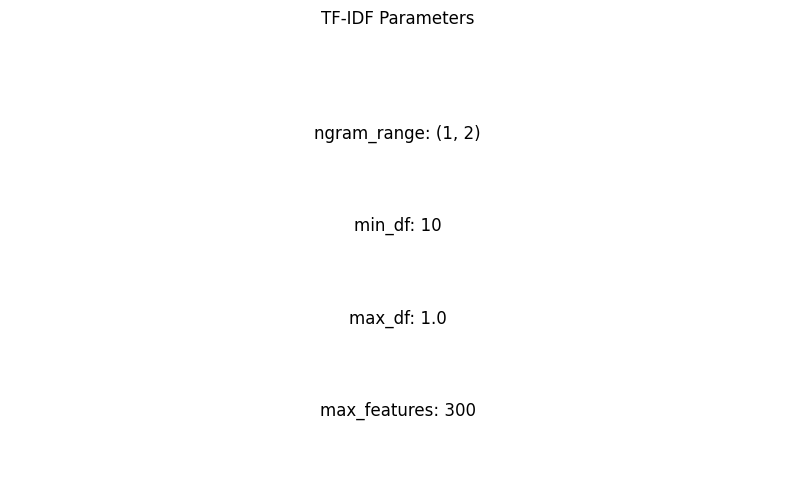

In [ ]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

import matplotlib.pyplot as plt

# Define the parameters
parameters = {
    "ngram_range": (1, 2),
    "min_df": 10,
    "max_df": 1.0,
    "max_features": 300
}

# Plot the parameters
plt.figure(figsize=(10, 6))
for i, (param, value) in enumerate(parameters.items(), start=1):
    plt.text(0.5, 1 - i * 0.2, f"{param}: {value}", ha='center', va='top', fontsize=12)
plt.axis('off')
plt.title('TF-IDF Parameters')
plt.show()


#TF-IDF NLP Modeli

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# NaN değerlerini boş bir dizeyle değiştir
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Define and configure the TfidfVectorizer
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

# Transform the training data
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train)

# Transform the test data
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)




[[0.         0.         0.         ... 0.24336463 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(20000, 300)


# Random Forest

Accuracy:  0.79115


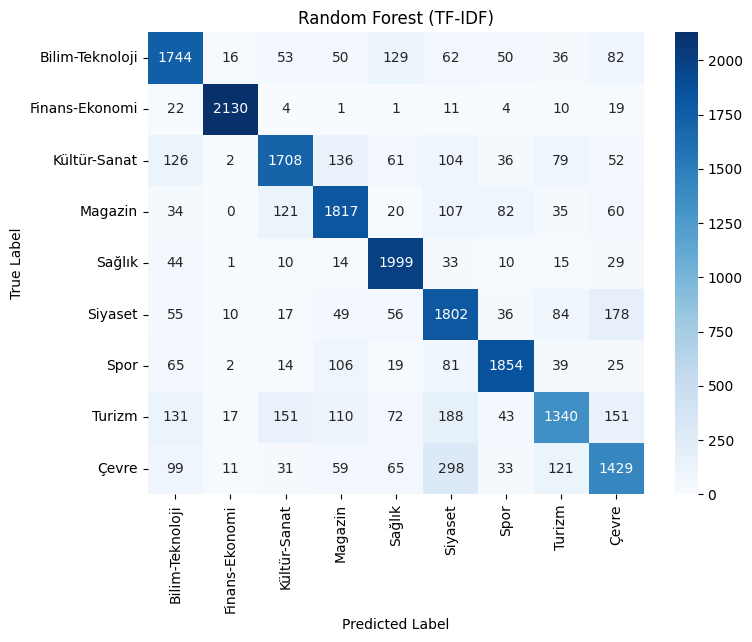

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
model  = RandomForestClassifier(random_state=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels_test, model_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Random Forest (TF-IDF)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Logistic Regression

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy:  0.78345


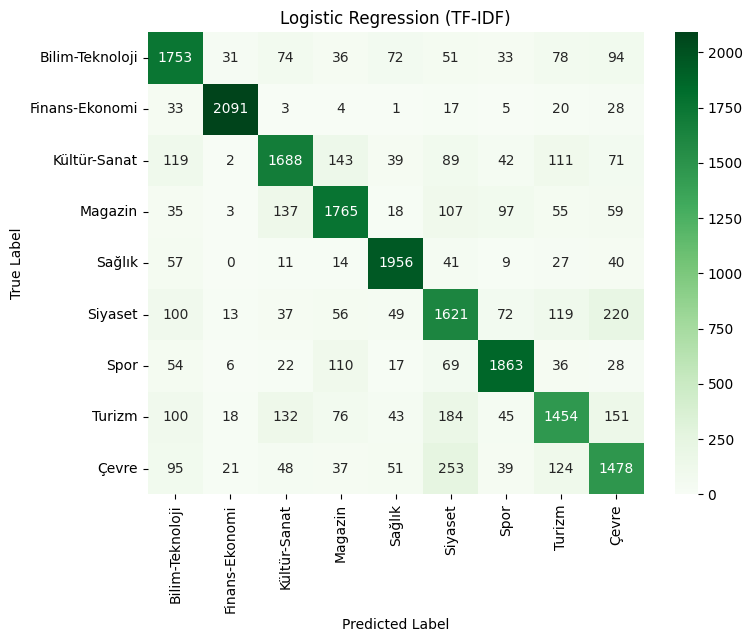

In [ ]:
model = LogisticRegression()
print(model.get_params())
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))

# Calculate confusion matrix
conf_matrix_lr = confusion_matrix(labels_test, model_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Logistic Regression (TF-IDF)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Accuracy remains the same after hyper paramter tuning

# Decision Tree

Accuracy:  0.6609


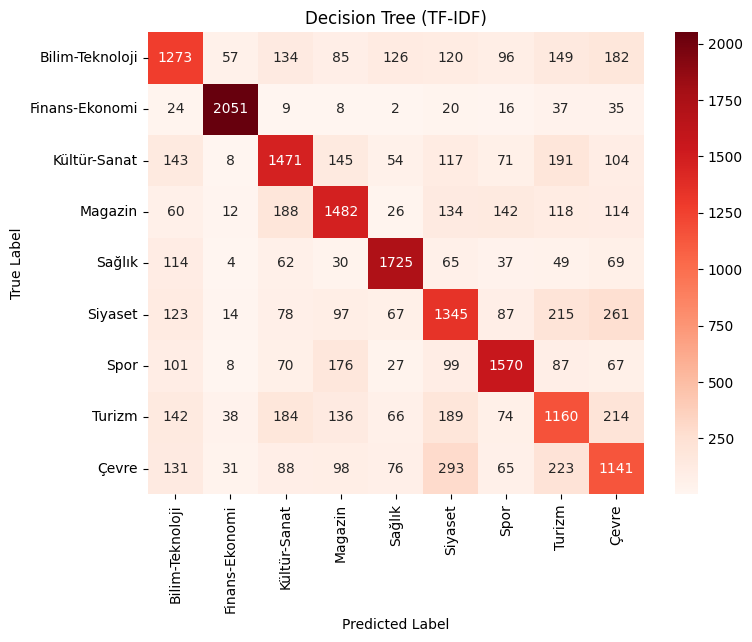

In [ ]:
model = DecisionTreeClassifier(random_state=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))

# Calculate confusion matrix
conf_matrix_dt = confusion_matrix(labels_test, model_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Reds',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Decision Tree (TF-IDF)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# GaussianNB

Accuracy:  0.66235


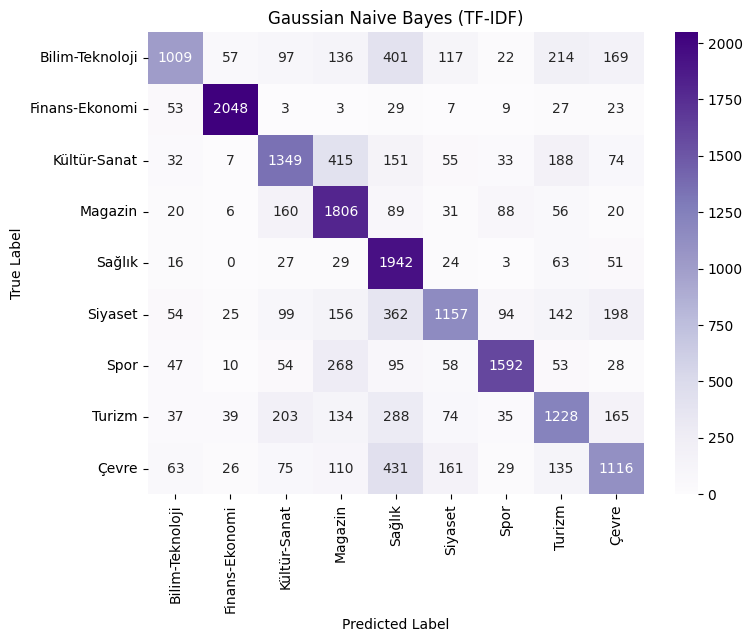

In [ ]:
model = GaussianNB()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))

# Calculate confusion matrix
conf_matrix_nb = confusion_matrix(labels_test, model_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Gaussian Naive Bayes (TF-IDF)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Doc2Vec

Bu kısım, gensim kütüphanesi kullanılarak Doc2Vec modeli için giriş verilerinin hazırlanmasını sağlar. Özetle:

label_sentences Fonksiyonu: Bu fonksiyon, her bir metin belgesine bir etiket atanmasını sağlar. Gensim'in Doc2Vec uygulaması, her bir belgenin bir etiketle ilişkilendirilmesini gerektirir. label_sentences fonksiyonu, her belgenin bir etiketle (örneğin, "TRAIN_0", "TEST_1" gibi) ilişkilendirildiği TaggedDocument nesnelerini oluşturur.

Eğitim ve Test Veri Kümesinin Etiketlenmesi: label_sentences fonksiyonu, eğitim ve test veri kümelerinin temizlenmiş haber gövdelerini alır ve her birini bir etiketle ilişkilendirilmiş TaggedDocument nesnelerine dönüştürür. Bu, eğitim ve test verilerinin hazır hale getirilmesini sağlar.

Tüm Veri Kümesinin Birleştirilmesi: Eğitim ve test veri kümeleri, bu adımda birleştirilir. Bu, Doc2Vec modelinin tüm veri kümesi üzerinde eğitilmesini sağlar. all_data değişkeni, eğitim ve test veri kümesinin birleştirilmiş halini temsil eder.

Sonuç olarak, bu adımlar, Doc2Vec modelinin kullanımı için giriş verilerinin hazırlanmasını sağlar. Bu model, belgelerin benzersiz sayısal gömülmesini oluşturur, böylece metin verileri üzerindeki ilişkileri öğrenmek için kullanılabilir.

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []


    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))

    return labeled



X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
all_data[0:2]

[TaggedDocument(words=['fıkıh', 'siyer', 'hadis', 'kelam', 'benzeri', 'dersleri', 'aldık', 'yasin', 'fetih', 'surelerini', 'ezberledik', 'arkadaşlarımız', 'maşallah', 'okulla', 'birlikte', 'hafızlık', 'eğitimini', 'birlikte', 'yürüterek', 'hafız', 'oldular', 'dedi', 'imam', 'hatip', 'manevi', 'güç', 'yksde', 'türkiye', '132incisi', 'olan', 'faruk', 'sartık', 'imam', 'hatipte', 'teknik', 'bilgilerin', 'yanı', 'sıra', 'manevi', 'donanımla', 'üniversite', 'sınavlarına', 'hazırlandıklarını', 'kaydetti', 'faruk', 'sartık', 'eşit', 'ağırlık', 'puan', 'türünde', 'türkiye', '132incisi', 'oldum', 'koç', 'üniversitesi', 'ekonomi', 'bölümünü', 'kazandım', 'bizim', 'okul', 'imam', 'hatiplerin', 'akademik', 'başarısı', 'ortada', 'inşallah', 'ihlnin', 'manevi', 'atmosferini', 'üniversite', 'ortamımıza', 'kariyerimize', 'yansıtarak', 'türkiyeye', 'hayırlı', 'hizmetlerde', 'bulunacağız', 'şeklinde', 'konuştu', 'yabancı', 'dil', 'eğitiminde', 'ihl', 'farkı', 'yksde', 'sayısal', 'puan', 'türünde', 'türk

Bu işlem, Doc2Vec modelinin belirli bir veri kümesine (burada eğitim ve test veri kümeleri) uygun bir şekilde eğitilmesini sağlar. Sonuç olarak, her belgenin vektörel temsilleri elde edilir ve bu vektörler daha sonra makine öğrenimi modelleri için giriş olarak kullanılabilir.

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(2):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 100000/100000 [00:00<00:00, 2136637.05it/s]


Fonksiyonun sonucunda, eğitim ve test veri kümesinin Doc2Vec modelinden elde edilen belge vektörleri, numpy dizileri olarak döndürülür. Bu belge vektörleri, daha sonra makine öğrenimi modelleri için giriş olarak kullanılabilir.








In [ ]:
import numpy as np
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

# Logistic Regression

accuracy 0.895


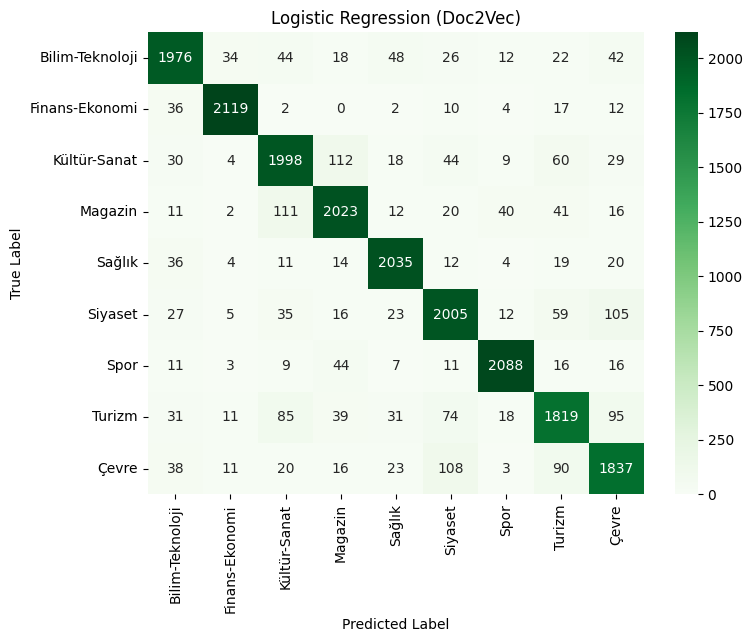

In [ ]:
model = LogisticRegression(n_jobs=1, C=1e5)
model = model.fit(train_vectors_dbow, y_train)
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))

# Calculate confusion matrix
conf_matrix_lr_doc2vec = confusion_matrix(y_test, model_prediction)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr_doc2vec, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Logistic Regression (Doc2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#Gaussian NB

accuracy 0.83135


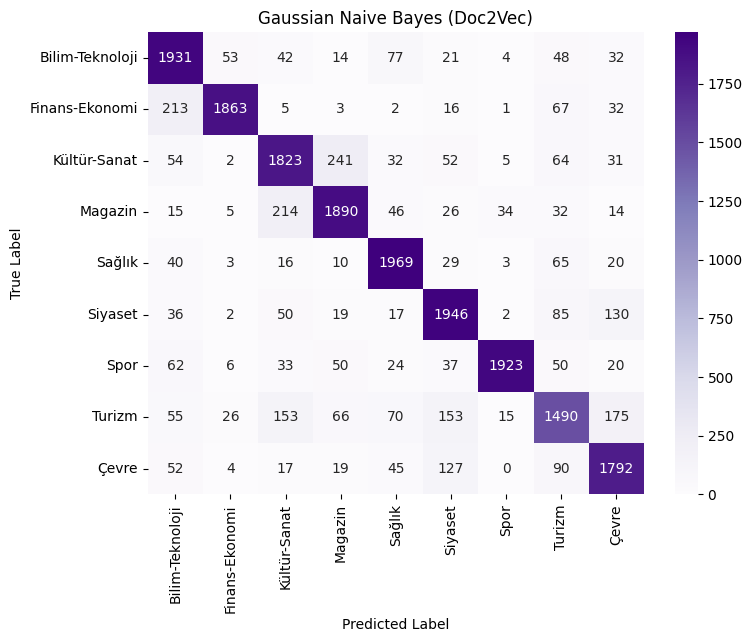

In [ ]:
model = GaussianNB()
model = model.fit(train_vectors_dbow, y_train)
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))

# Calculate confusion matrix
conf_matrix_nb_doc2vec = confusion_matrix(y_test, model_prediction)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb_doc2vec, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Gaussian Naive Bayes (Doc2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Random Forest

accuracy 0.8853


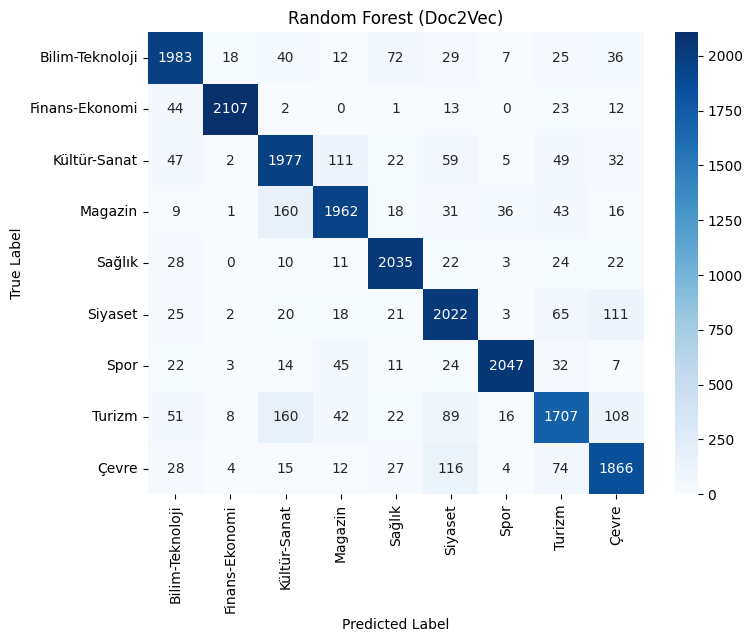

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model = model.fit(train_vectors_dbow, y_train)
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))

# Calculate confusion matrix
conf_matrix_rf_doc2vec = confusion_matrix(y_test, model_prediction)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_doc2vec, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Random Forest (Doc2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Decision Tree

accuracy 0.6342


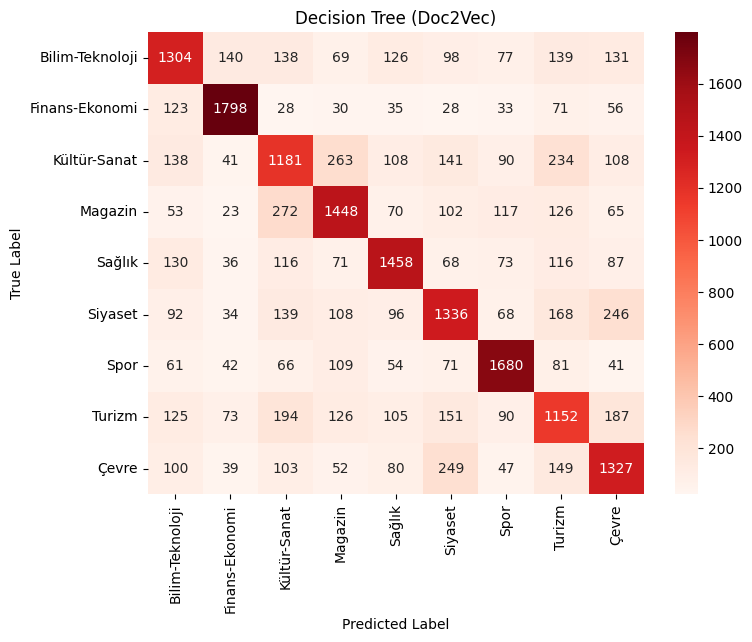

In [ ]:
model = DecisionTreeClassifier()
model = model.fit(train_vectors_dbow, y_train)
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))

# Calculate confusion matrix
conf_matrix_dt_doc2vec = confusion_matrix(y_test, model_prediction)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt_doc2vec, annot=True, fmt='d', cmap='Reds',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Decision Tree (Doc2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Word2Vec



In [ ]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# Verileri uygun formata dönüştürmek için bir önişlem sınıfı tanımlayalım
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        processed_texts = []
        for text in X:
            processed_texts.append(text.words)
        return processed_texts

# Veri kümesi üzerinde Word2Vec modelini eğitmek için bir fonksiyon tanımlayalım
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    model.train(sentences, total_examples=len(sentences), epochs=10)
    return model


In [ ]:
# Veri kümesi
X_train_processed = TextPreprocessor().fit_transform(X_train)

In [ ]:
# Word2Vec modelini eğit
word2vec_model = train_word2vec_model(X_train_processed)

In [ ]:
# Belge vektörlerini elde etmek için bir fonksiyon tanımlayalım
def get_average_word_vectors(words, model, vector_size):
    feature_vector = np.zeros((vector_size,), dtype="float32")
    num_words = 0
    for word in words:
        if word in model.wv:
            feature_vector = np.add(feature_vector, model.wv[word])
            num_words += 1
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

In [ ]:
# Eğitim ve test veri kümesi için belge vektörlerini elde et
X_train_word2vec = np.array([get_average_word_vectors(words, word2vec_model, 100) for words in X_train_processed])
X_test_processed = TextPreprocessor().fit_transform(X_test)
X_test_word2vec = np.array([get_average_word_vectors(words, word2vec_model, 100) for words in X_test_processed])

#Random Forest

Random Forest Accuracy: 0.8965


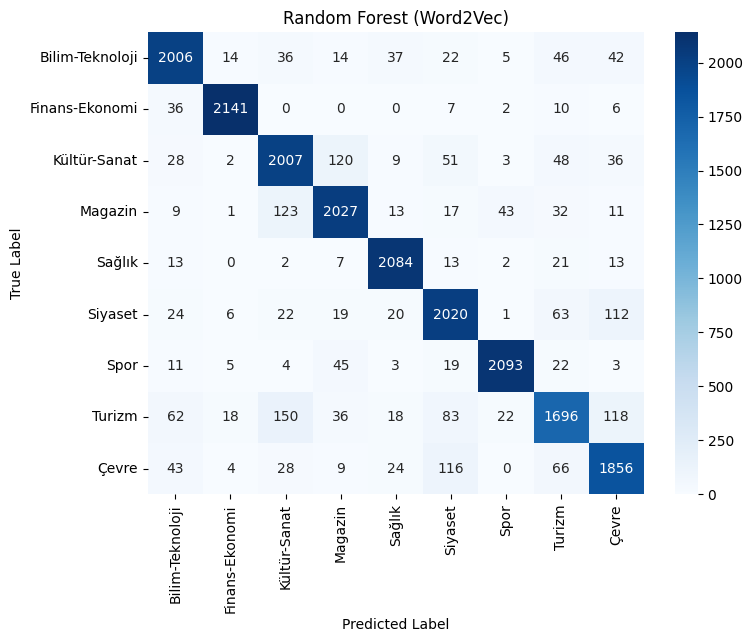

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train_word2vec, y_train)
predictions_rf = model_rf.predict(X_test_word2vec)
print("Random Forest Accuracy:", accuracy_score(y_test, predictions_rf))

# Calculate confusion matrix
conf_matrix_rf_word2vec = confusion_matrix(y_test, predictions_rf)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_word2vec, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Random Forest (Word2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



#Logistic Regression

Logistic Regression Accuracy: 0.8988


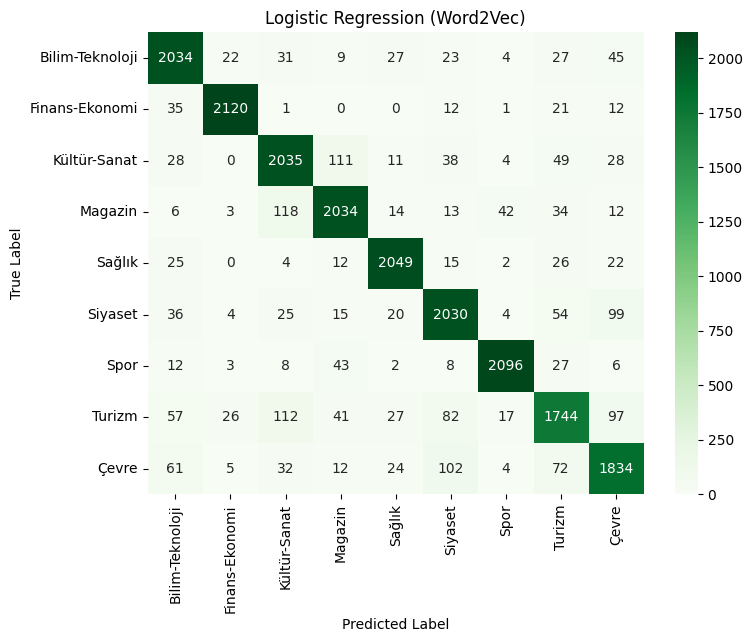

In [ ]:
# Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train_word2vec, y_train)
predictions_lr = model_lr.predict(X_test_word2vec)
print("Logistic Regression Accuracy:", accuracy_score(y_test, predictions_lr))

# Calculate confusion matrix
conf_matrix_lr_word2vec = confusion_matrix(y_test, predictions_lr)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr_word2vec, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Logistic Regression (Word2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#Decision Tree

Decision Tree Accuracy: 0.77945


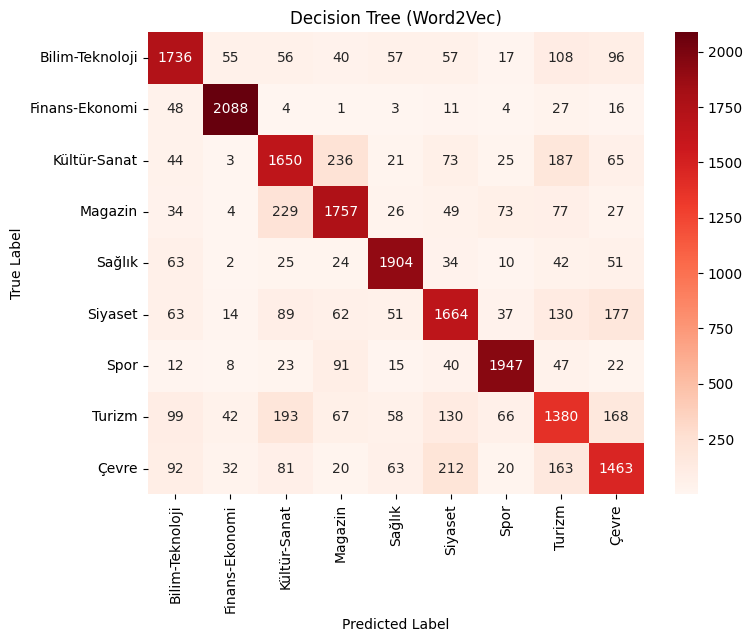

In [ ]:
# Decision Tree
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_word2vec, y_train)
predictions_dt = model_dt.predict(X_test_word2vec)
print("Decision Tree Accuracy:", accuracy_score(y_test, predictions_dt))

# Calculate confusion matrix
conf_matrix_dt_word2vec = confusion_matrix(y_test, predictions_dt)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt_word2vec, annot=True, fmt='d', cmap='Reds',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Decision Tree (Word2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#Gaussian NB

Gaussian Naive Bayes Accuracy: 0.81275


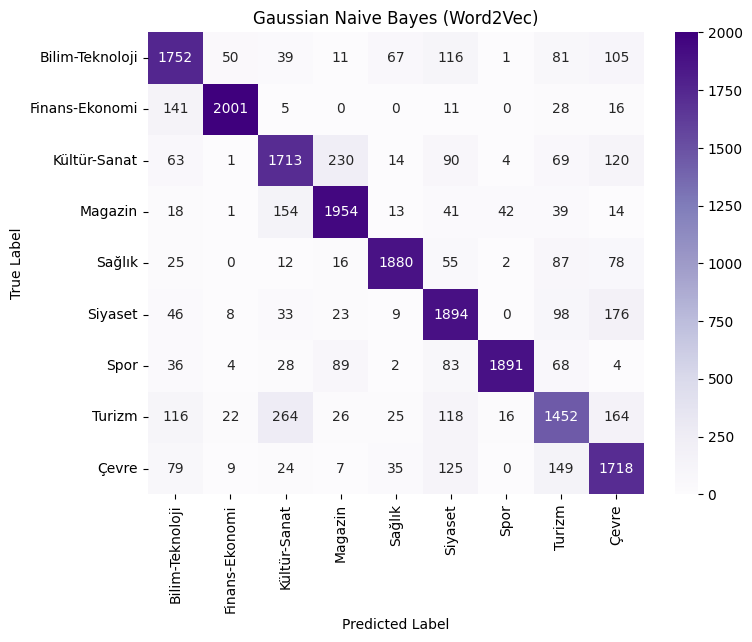

In [ ]:
# Gaussian Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train_word2vec, y_train)
predictions_nb = model_nb.predict(X_test_word2vec)
print("Gaussian Naive Bayes Accuracy:", accuracy_score(y_test, predictions_nb))

# Calculate confusion matrix
conf_matrix_nb_word2vec = confusion_matrix(y_test, predictions_nb)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb_word2vec, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Gaussian Naive Bayes (Word2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
